# Relax Inc. Instructions:

The data is available as two attached CSV files:
takehome_user_engagement. csv
takehome_users . csv
The data has the following two tables:
1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
    * PERSONAL_PROJECTS: invited to join another user's personal workspace
    * GUEST_INVITE: invited to an organization as a guest (limited permissions)
    * ORG_INVITE: invited to an organization (as a full member)
    * SIGNUP: signed up via the website
    * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).
2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.


Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period , identify which factors predict future user adoption .


We suggest spending 12
hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

## Begin by loading up the data and previewing it

In [1]:
import pandas as pd
import numpy as np

users = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [2]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


It looks like to label the users as active, the activity log must be sampled per user and their activity must be determined. 
### Label Users as adopted

In [4]:
import datetime

#set the time_stamp to datetime and the set it as the index
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp', drop= True)

In [5]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = engage.loc[engage['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [6]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [7]:
print(sum(users['adopted_user']))
print(round(sum(users.adopted_user)* 100/len(users.adopted_user)))

1656
14


So it appears that there are only 1656 active users in the dataframe, about 14% of the total users. Keep this in mind later since it means that the classes will need to be balanced later for analysis.

### Data Wrangling
More data wrangling. Convert all time stamps to datetime objects.

In [8]:
# set creation_time
users.creation_time = pd.to_datetime(users.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

Subtract the` creation_time` from the `last_session_creation_time` to create a feature that combines the two in a meaningful way. This will give us feature `usage_length` that basically indicates how long a user has been active. 

In [9]:
#now set that to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

Looking good so far, but we can also use email domain as a feature as well. There are only a few main ones, so I will label the less popular domains as other. 

In [10]:
users['email_provider'] = [x.split('@')[1] for x in users.email]#select out the domain
top_emails = users.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]

The same can be done with users, but first the emtpy values must be filled to be categorized.

In [11]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

Very quickly, remove the columns containing features that won't be useful for analysis. This includes `object_id`	`creation_time`	`name`	`email` and `last_session_creation_time`.

In [12]:
feature_df = users.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

Using `sklearn.preprocessing.LabelEncoder` we can easily engineer categorical labels for each categorical feature.

In [13]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users['email_provider'])
feature_df.email_provider = email_labels

In [14]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,-14400.0,6
1,1,0,0,56,316.0,1,11736000.0,2
2,1,0,0,298,1525.0,0,-14400.0,2
3,0,0,0,1104,5151.0,0,72000.0,6
4,0,0,0,1127,5240.0,0,414000.0,6


This is the fully engineered feature set. Looks good so far.
### Analysis
Since we have a small feature set and sample size, `Kneighbors` and `RandomForestClassifier` are both good choices for this data set. However, we have a mix of categorical and numerical data so `RandomForestClassifier` will be easiest to implement.

In [15]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9704545454545455

very promising results. As long as the classifier is intrepretable, it should reveal meaningful insight. Lets look at the metrics just to be sure.

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.87      0.89       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3361   46]
 [  71  482]]


considering that `RandomForestClassifier` is better at intrinsically describing data over predictive power, these results are very impressive, especially with imbalanced class representation. What this indicates to me is that the classifier is not overfit, making whatever feature importance it has assigned much more valid.
### Feature Importance
Whatever coefficients the classifier has assigned to the features will indicate which ones it found more useful in making the correct  classifications. 

In [18]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.925057
org_id                        0.021812
invited_by_user_id            0.021333
email_provider                0.015162
creation_source               0.009714
opted_in_to_mailing_list      0.003576
enabled_for_marketing_drip    0.003346
Name: coef, dtype: float64

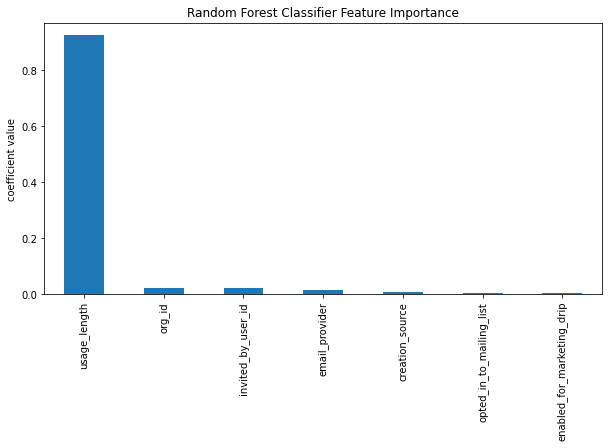

In [19]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

According to this analysis, `RandomForestClassifer` identified how long between when a user signed up and when their last active session to be the greatest indicator of whether or not they became an adopted user. Lets see what that means in a post hoc visualization

In [20]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [21]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]

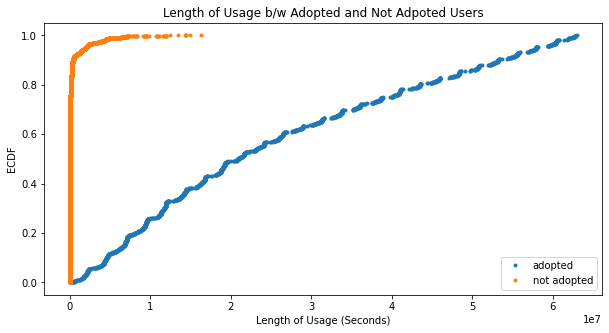

In [22]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Here it is apparent that at the maxium time usage of non-adopted users, approximately 60% of the active users have usage above that amount of time (approximately 230 days). 